In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import time

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13176315813264218545
]


In [1]:
def read_house_data(house):
    # path = '/kaggle/input/pakistan-residential-electricity-consumption/House{}.csv'.format(house)
    path = 'precon_dataset/House{}.csv'.format(house)
    df = pd.read_csv(path)
    df['Date_Time'] = df['Date_Time'].astype("datetime64[s]")
    df = df.set_index(df['Date_Time'].values)
    df.drop(['Date_Time'], axis=1, inplace=True)
    return df

df = {}
# for i in range(1,10):
#     df[i] = read_house_data(i)


# Hosue 2 and 4
df[1] = read_house_data(4)
df1_mains2 =  df[1].iloc[:,1:].sum(axis=1)
df[1].insert(loc = 1,column = 'Sum_kW',value = df1_mains2)
df[1] = df[1][:44640]

df[2] = read_house_data(10)
df2_mains2 =  df[2].iloc[:,1:].sum(axis=1)
df[2].insert(loc = 1,column = 'Sum_kW',value = df2_mains2)
df[2] = df[2][:44640]

NameError: name 'pd' is not defined

In [ ]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

In [80]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 31 days from 2018-06-01 to 2018-07-01.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01'] 

House 2 data contain 31 days from 2018-06-01 to 2018-07-01.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01'] 



In [28]:
df[1] = df[1].loc[:dates[1][30]]
df[2] = df[2].loc[:dates[2][30]]

print('House {} data has shape: '.format(1), df[1].shape)
print('House {} data has shape: '.format(2), df[2].shape)

House 1 data has shape:  (44640, 7)
House 2 data has shape:  (44640, 6)


Text(0.5, 1.0, 'House 2')

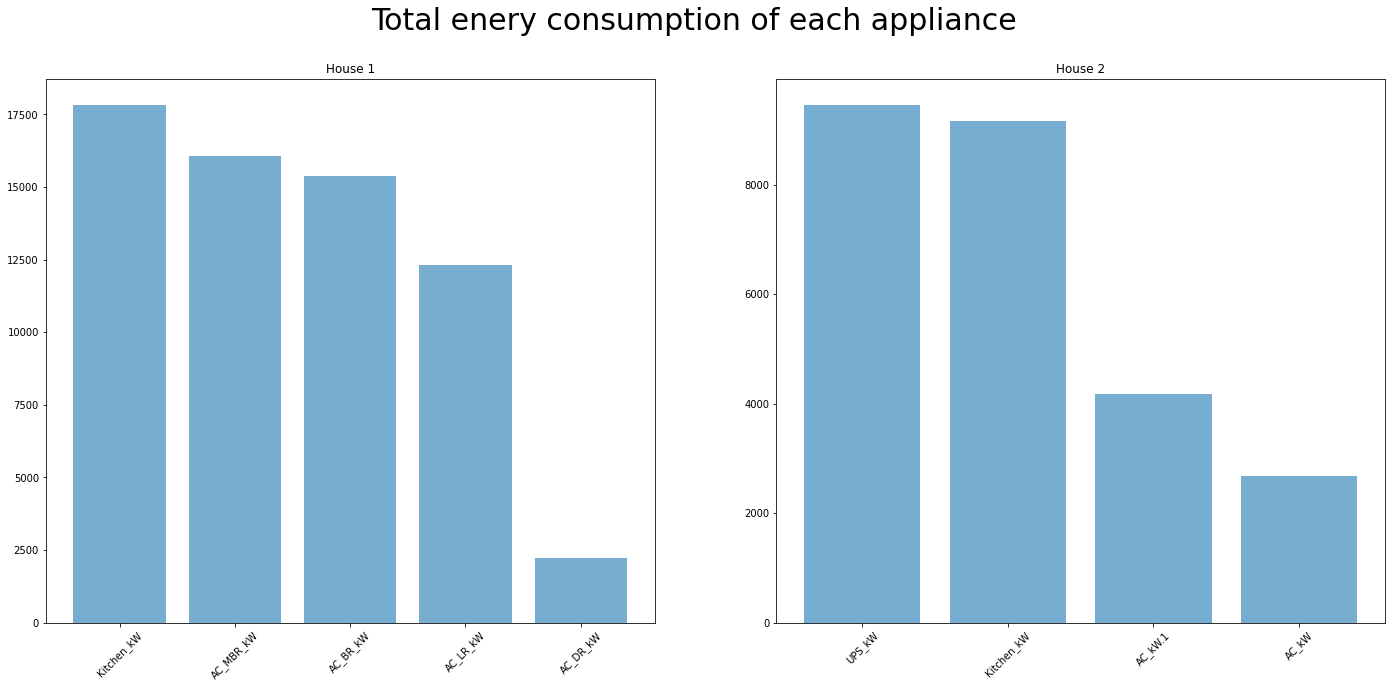

In [81]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6)
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')


In [33]:
# Separating house 1 data into train, validation and test data
# df1_train = df[1].loc[:dates[1][250]]
# df1_val = df[1].loc[dates[1][251]:dates[1][325]]
# df1_test = df[1].loc[dates[1][326]:]
# print('df_train.shape: ', df1_train.shape)
# print('df_val.shape: ', df1_val.shape)
# print('df_test.shape: ', df1_test.shape)

df1_train = df[1].loc[:dates[1][15]]
df1_val = df[1].loc[dates[1][15]:dates[1][17]]
df1_test = df[1].loc[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (23040, 7)
df_val.shape:  (4320, 7)
df_test.shape:  (20160, 7)


In [52]:
def build_lstm_model(layers):
    model = Sequential()
    i = 0
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i+1],
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))

    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([1,64,128,256, 1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [49]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back]
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 1)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [50]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:17], ['Usage_kW'], ['Kitchen_kW'])
X_test, y_test = process_data(df[1], dates[1][17:], ['Usage_kW'], ['Kitchen_kW'])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  16.58568549156189
(23630, 50, 1) (23630, 1) (19460, 50, 1) (19460, 1)


In [14]:
print(df[1].columns.values[2:])

['AC_DR_kW' 'Kitchen_kW' 'AC_BR_kW' 'AC_LR_kW' 'AC_MBR_kW']


In [58]:
start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train,
            batch_size=512,
            verbose=1,
            epochs=200,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
33/33 [==============================] - 142s 4s/step - loss: 0.0211 - val_loss: 0.0177
Epoch 2/200
33/33 [==============================] - 136s 4s/step - loss: 0.0189 - val_loss: 0.0169
Epoch 3/200
33/33 [==============================] - 136s 4s/step - loss: 0.0178 - val_loss: 0.0163
Epoch 4/200
33/33 [==============================] - 136s 4s/step - loss: 0.0173 - val_loss: 0.0159
Epoch 5/200
33/33 [==============================] - 137s 4s/step - loss: 0.0169 - val_loss: 0.0158
Epoch 6/200
33/33 [==============================] - 136s 4s/step - loss: 0.0165 - val_loss: 0.0155
Epoch 7/200
33/33 [==============================] - 136s 4s/step - loss: 0.0163 - val_loss: 0.0154
Epoch 8/200
33/33 [==============================] - 137s 4s/step - loss: 0.0161 - val_loss: 0.0158
Epoch 9/200
33/33 [==============================] - 138s 4s/step - loss: 0.0159 - val_loss: 0.0156
Epoch 10/200
33/33 [==============================] - 137s 4s/step - loss: 0.0158 - val_loss: 0.0156

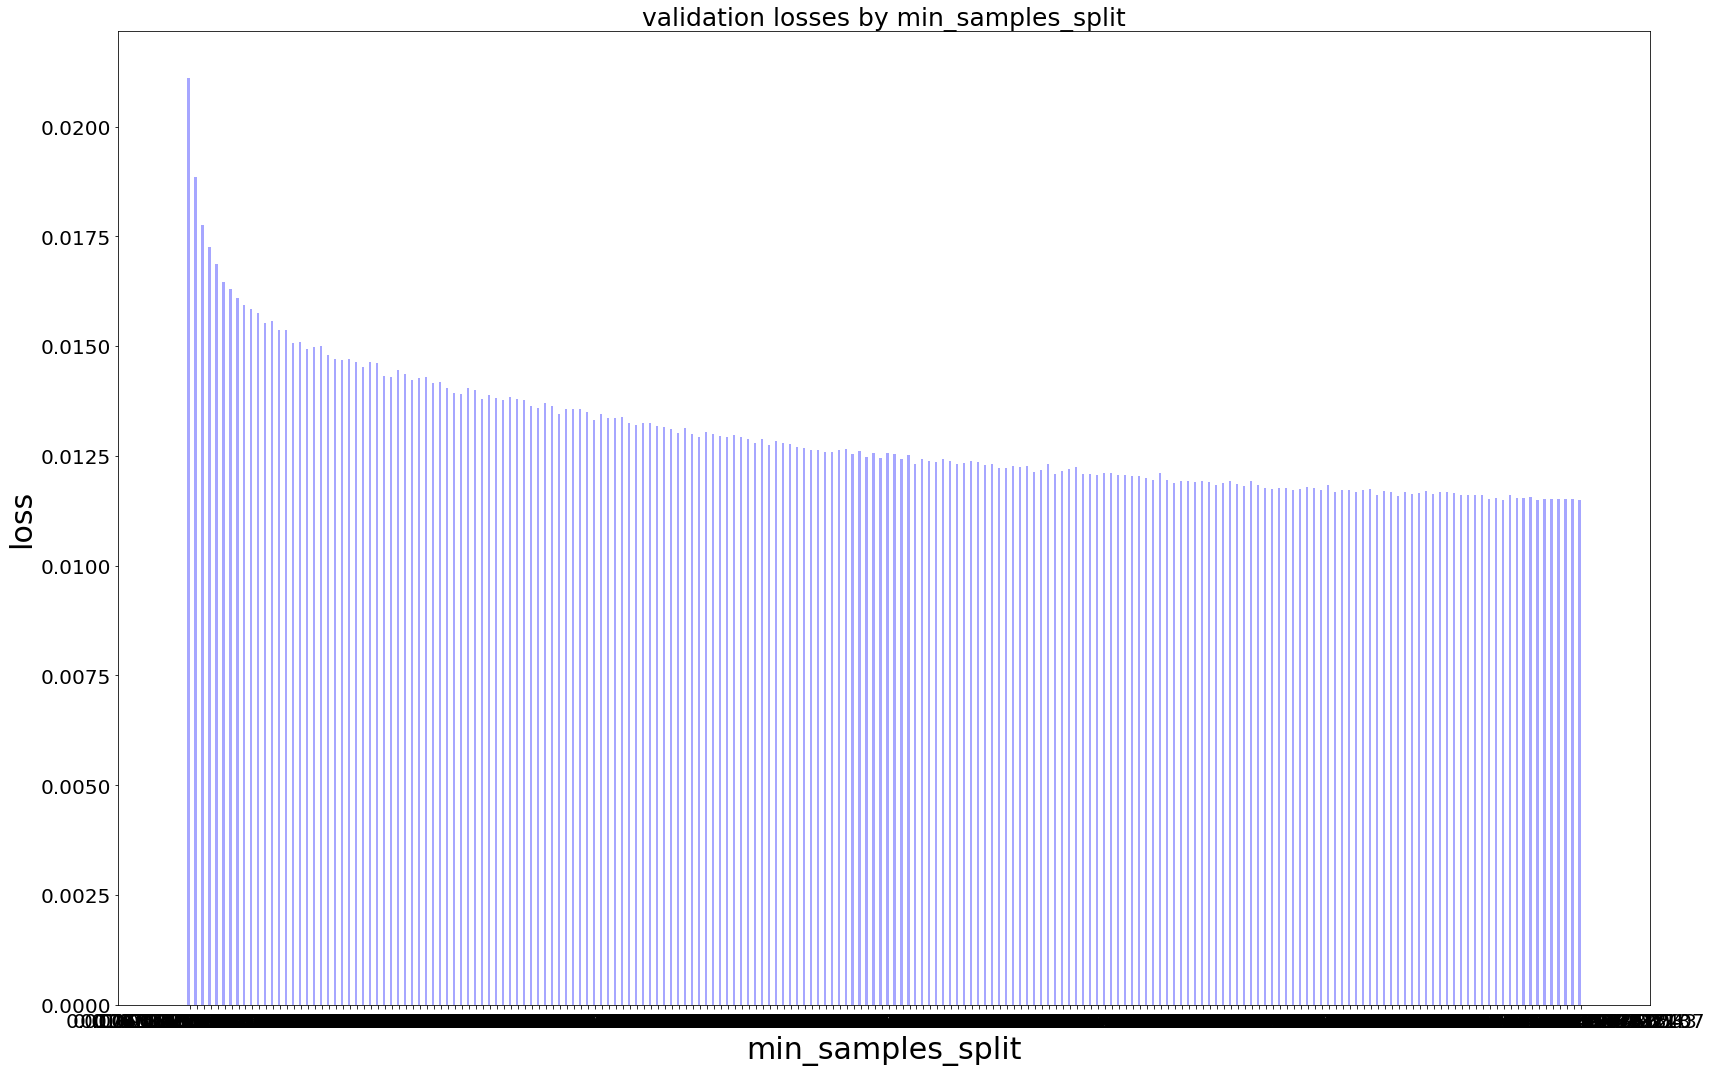

In [59]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.3
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()


train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [60]:
model = load_model('lstm_model_hosue4_usage_kitchen_200.hdf5')
# model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)


(19460,)


In [61]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))


mse_loss_lstm = mse_loss(pred_lstm, y_test)
mae_loss_lstm = mae_loss(pred_lstm, y_test)
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  0.027483469284069192
Mean absolute error on the test set:  0.13550793915907455


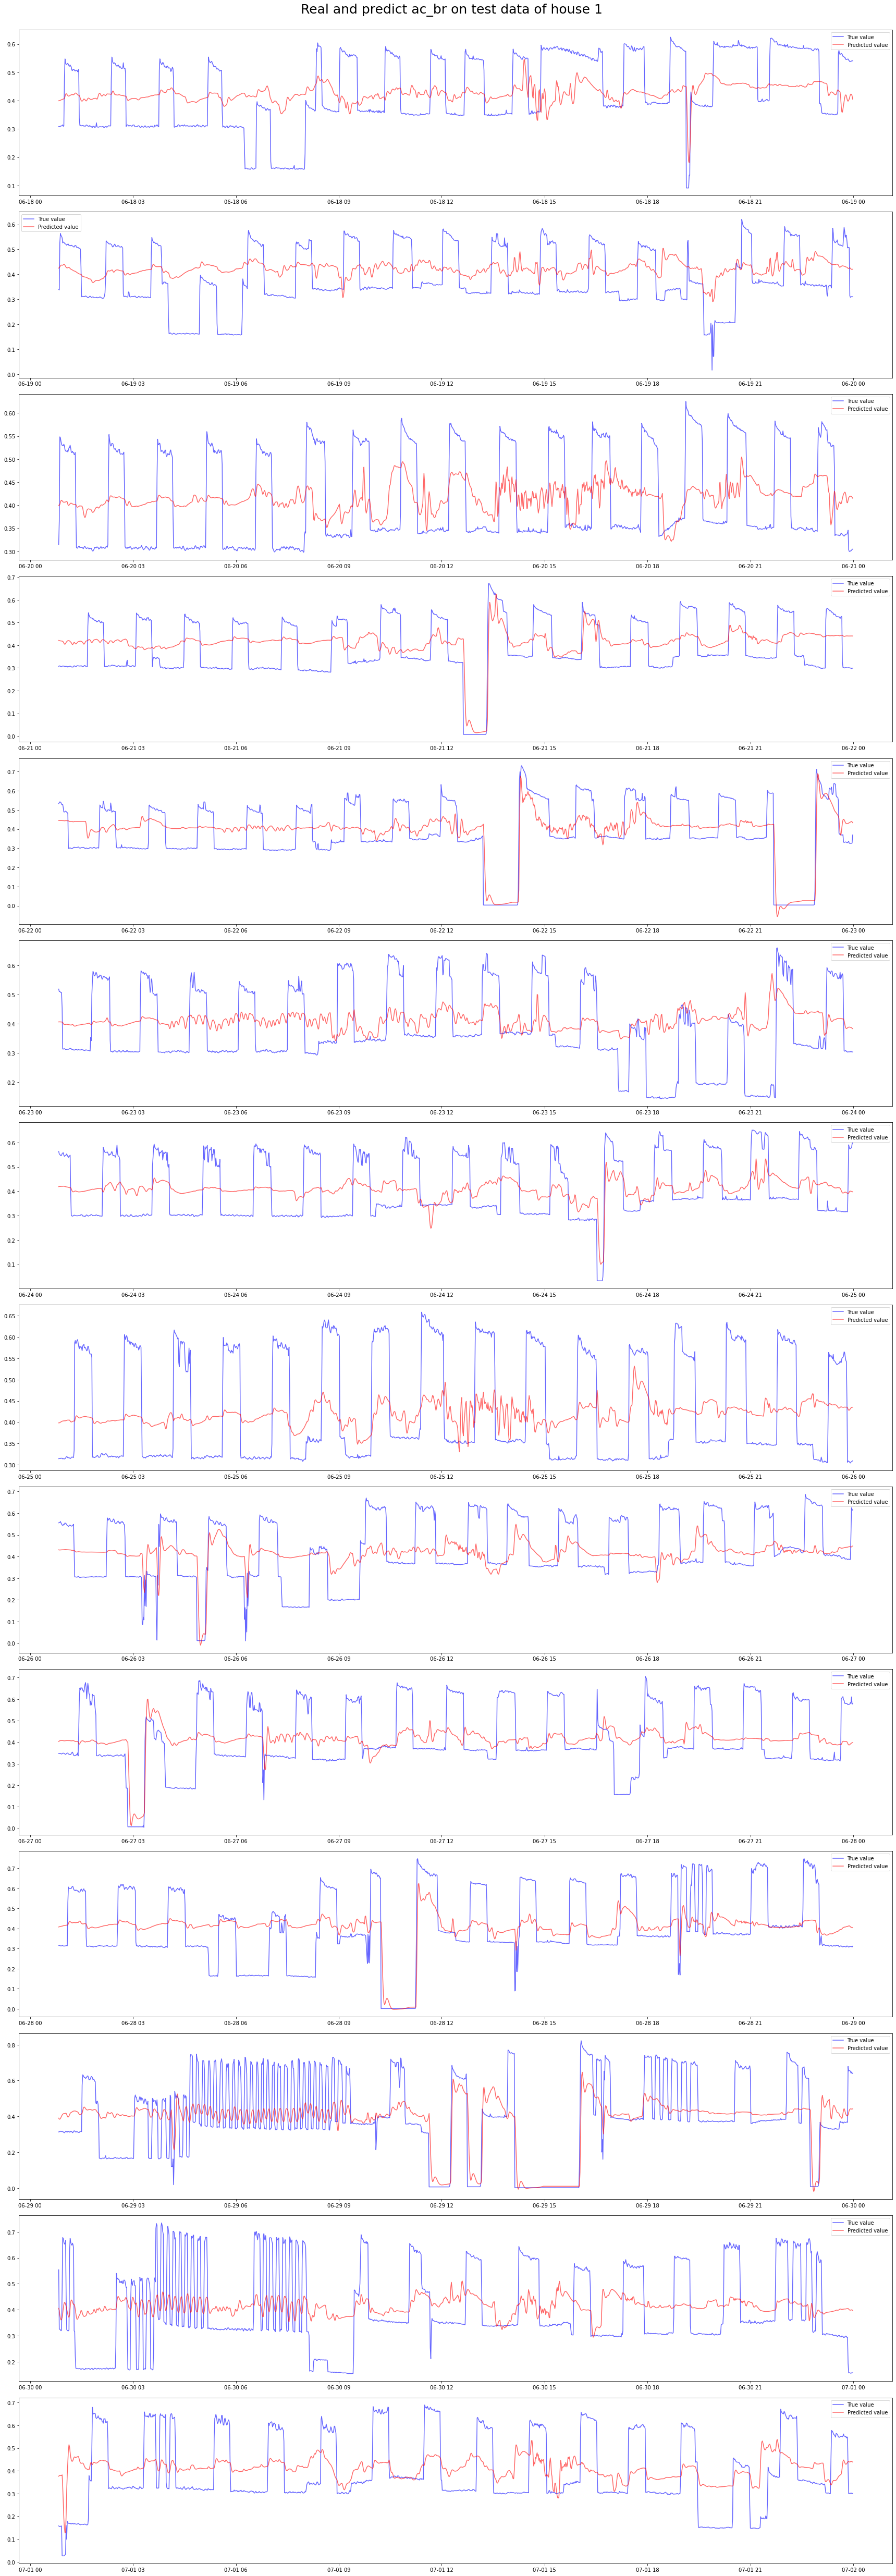

In [62]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.97)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        display()
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = l+len(ind)

plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test,
              'Real and predict ac_br on test data of house 1', look_back = 50)

### Test LST model on house 2

In [82]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW'], ['Kitchen_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

Process data time:  18.24794626235962
(43090,)


In [83]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.012829558516056614
Mean absolute error on the test set:  0.08458933647862557


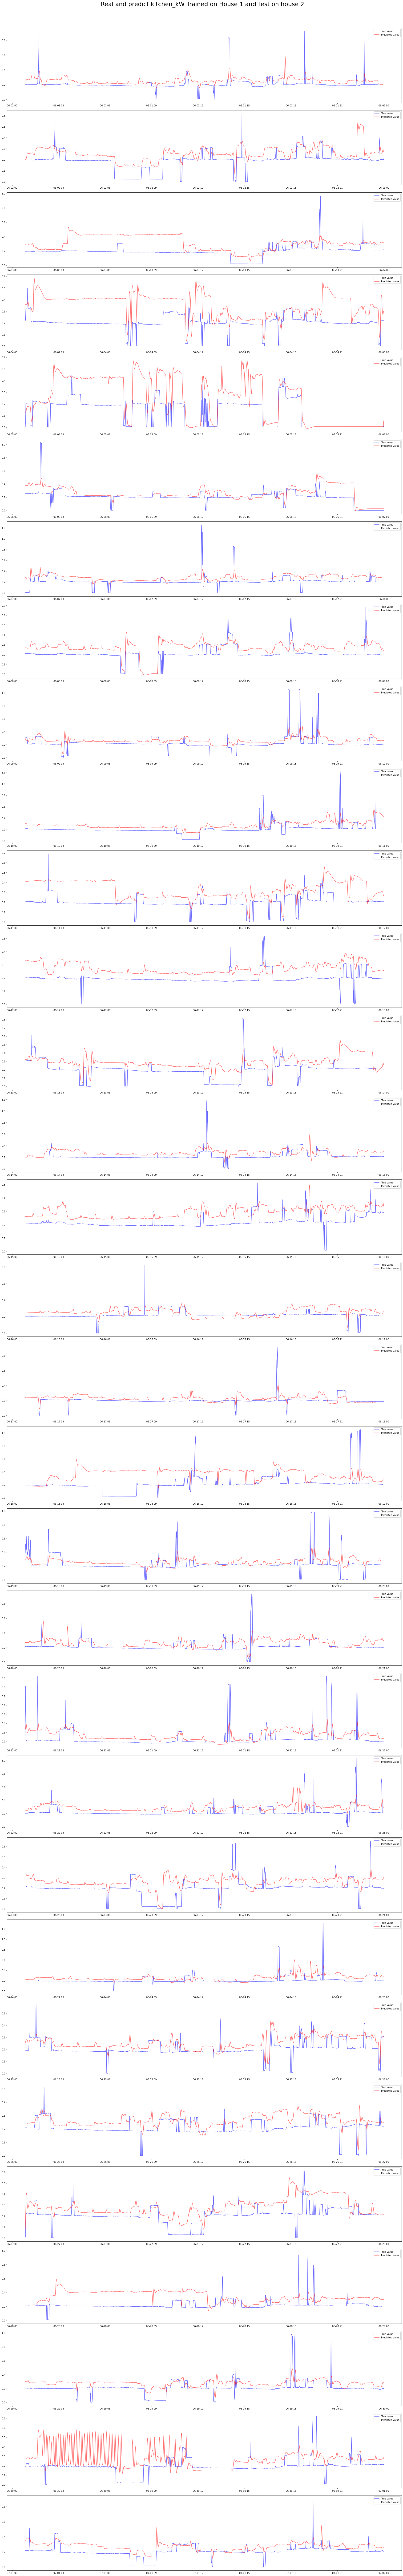

In [84]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back = 50)

Real and Predicted Data for All Appliences Train on House 1 and Tested on Hosue 2

In [90]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW'], ['UPS_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

Process data time:  18.98403000831604
(43090, 1)
Process data time:  18.3519229888916
(43090,)


In [92]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
print(pred_lstm_h2.shape)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.016515076999271027
Mean absolute error on the test set:  0.09782079693195483
(43090,)
Mean square error on test set:  0.016515076999271027
Mean absolute error on the test set:  0.09782079693195483


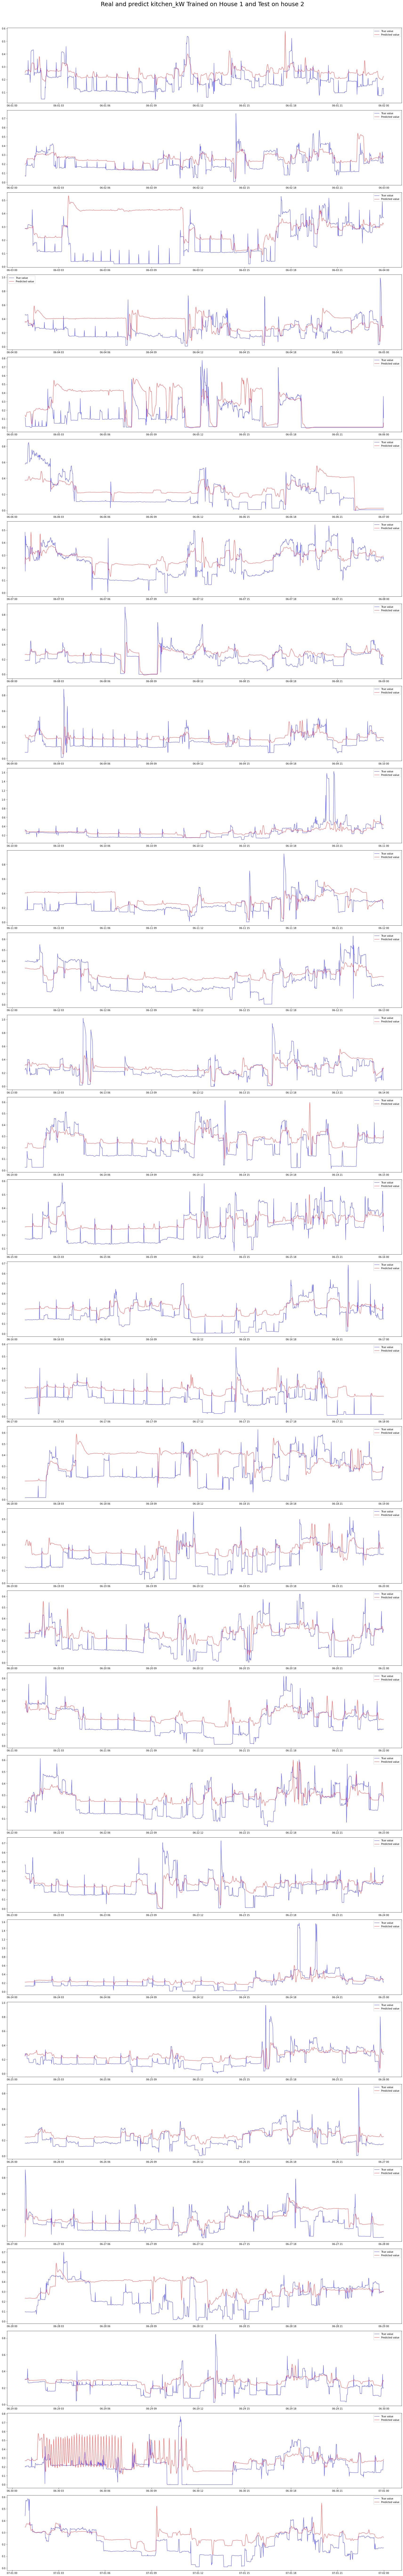

In [93]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back = 50)

Process data time:  17.385003805160522
(43090,)
(43090,)
Mean square error on test set:  0.11433618119808607
Mean absolute error on the test set:  0.286646902711191


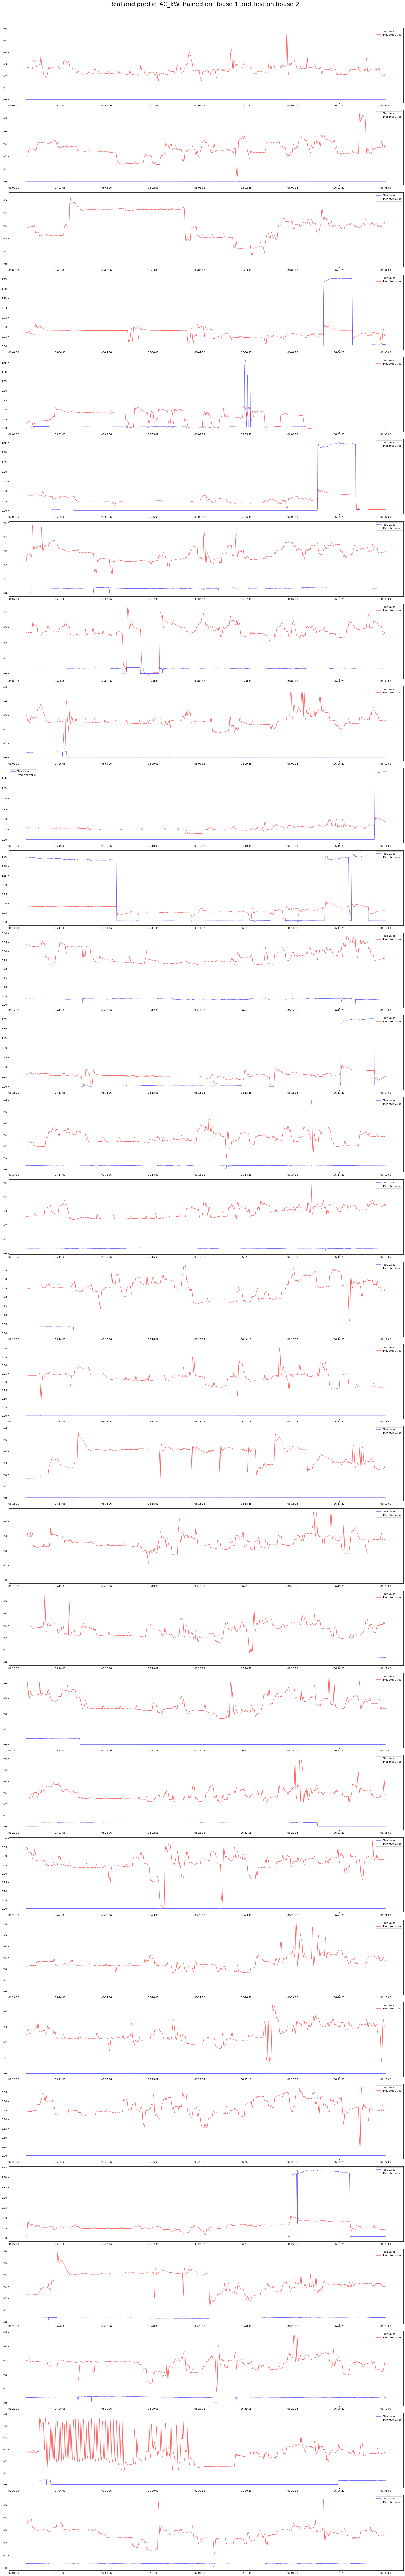

In [94]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW'], ['AC_kW'])
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(y_2.shape)

pred_lstm_h2 = model.predict(X_2).reshape(-1)
print(pred_lstm_h2.shape)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2,
              'Real and predict AC_kW Trained on House 1 and Test on house 2', look_back=50)